# Perfromance metrics and plots for pre-trained models

In [1]:
#Adding all necessary imports

import numpy             as np
import matplotlib.pyplot as plt
import awkward           as ak
import matplotlib        as mpl
import vector
import sys
import os

os.chdir('/workspace/workDir/')
sys.path.append(os.getcwd())

from utils.misc import sparse_to_awkward, awkward_to_vector, sort_and_pad
from utils.jets import truth_match

## Loading from memory all files/models

In [9]:
from utils.image import pad

sample_names = ['vbfhh', 'jz']
conv_size    = 7

data = {}
for i_sample in sample_names:
    print(f'[INFO]: Loading {i_sample} sample')
    in_file = ak.from_parquet(f'../samples/{i_sample}/{i_sample}_test.parquet')
    data[i_sample] = {}
    data[i_sample]["Towers_NoPu"] = pad(in_file["Towers_NoPU" ].to_numpy(), conv_size//2)
    data[i_sample]["GenJets"]     = in_file["GenJet"]
    data[i_sample]["Jets"]        = in_file["Jet"]

from tensorflow     import keras
from json           import load
from modules.layers import SlidingConeSum, LocalMaxMask

custom_objects = {
    'SlidingConeSum': SlidingConeSum,
    'LocalMaxMask'  : LocalMaxMask,
}

model      = keras.models.load_model('out/trained_model_sggF_SM_HH4b_train_w[7, 3]_b512_l2_nc[16, 32]_nd[32, 16].keras', custom_objects=custom_objects)
train_data = load(open('out/train_model_sggF_SM_HH4b_train_w[7, 3]_b512_l2_nc[16, 32]_nd[32, 16]_history.json', 'r'))

[INFO]: Loading vbfhh sample
[INFO]: Loading jz sample


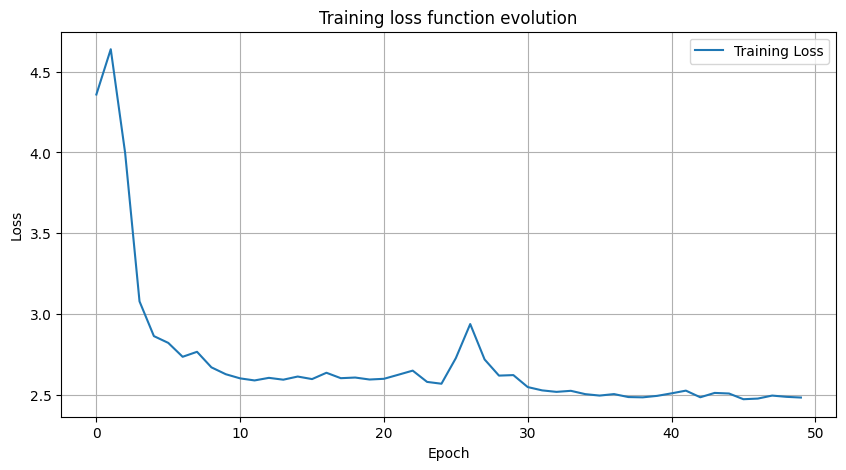

In [3]:
# Plot loss function

plt.figure(figsize=(10,5))
plt.plot(train_data['loss'], label='Training Loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss function evolution')
plt.legend()
plt.show()

In [4]:
# Running inference on validation sample

found_jets = model.predict(data['vbfhh']['Towers_NoPu'])

1563/1563 [==============================] - 9s 6ms/step


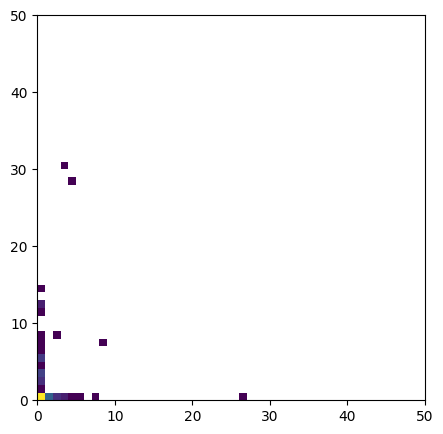

In [5]:
# Event displays for a couple of events

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist2d(
    data['vbfhh']['Towers_NoPu'][0, ..., 0].flatten(),
    data['vbfhh']['Towers_NoPu'][0, ..., 1].flatten(),
    bins=(50, 50),
    range=((0, 50), (0, 50)),
    norm=mpl.colors.LogNorm()
)
plt.show()

### Look into the physics metrics (i.e. Trigger efficiency)

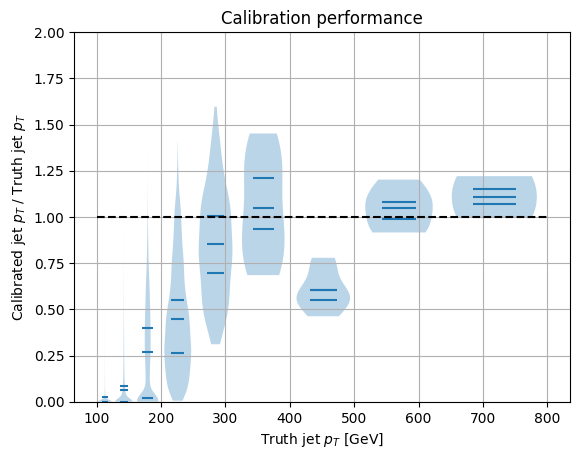

In [6]:
from utils.image import tower_to_vector


calib_jets = sort_and_pad(sparse_to_awkward(tower_to_vector(found_jets)),10)
truth_jets = sort_and_pad(awkward_to_vector(data['vbfhh']['GenJets']), 10)

bin_edges = np.logspace(np.log10(100), np.log10(800), 10)

mask = (calib_jets[...,3].rho > 0) & (truth_jets[...,3].rho > 0)

matched_calib_pt = calib_jets[mask].pt
matched_truth_pt = truth_jets[mask].pt

my_data = [(matched_calib_pt/matched_truth_pt)[(matched_truth_pt > min_pt) & (matched_truth_pt < max_pt)] for min_pt, max_pt in zip(bin_edges[:-1], bin_edges[1:])]
my_data = [np.array([0]) if len(d) == 0 else d for d in my_data]

violin_pt = plt.violinplot(
    my_data,
    positions   = 0.5*(bin_edges[:-1] + bin_edges[1:]),
    widths      = 0.8*np.diff(bin_edges),
    showmeans   = True,
    quantiles   = [[0.32, 0.68]]*len(my_data),
    showextrema = False,
    points       = 1000,
)

plt.hlines(1, np.min(bin_edges), np.max(bin_edges), colors='k', linestyles='dashed')
plt.ylim(0, 2)
plt.xlabel('Truth jet $p_T$ [GeV]')
plt.ylabel('Calibrated jet $p_T$ / Truth jet $p_T$')
plt.title('Calibration performance')
plt.grid()
plt.show()

In [16]:
# Get background samples to find cut for turn-on curve

from tqdm import tqdm

base_rate = 40e3

def get_rate(x, weights, threshold):
    return np.asarray(weights)[np.asarray(x) > threshold].sum() / weights.sum() * base_rate

def get_threshold(x, weights, target_rate, tol=1e-12, max_iter=100):
    if get_rate(x, weights, threshold=0) < target_rate:
        return 0.0
    
    lo, hi = np.min(x), np.max(x)
    for _ in tqdm(range(max_iter)):
        mid = 0.5 * (lo + hi)
        rate = get_rate(x, weights, threshold=mid)
        
        if abs(rate - target_rate) < tol:
            return mid
        elif rate > target_rate:
            lo = mid
        else:
            hi = mid

    return 0.5 * (lo + hi)

thresholds = {}

thresholds['ptj1'] = get_threshold(data['jz']['GenJets'][:,0].rho, np.ones(len(data['jz']['GenJets'][:,0].rho)), target_rate=25)
thresholds['ptj4'] = get_threshold(data['jz']['GenJets'][:,3].rho, np.ones(len(data['jz']['GenJets'][:,3].rho)), target_rate=100)    

print(thresholds)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4714.50it/s]

{'ptj1': 205.73472595214844, 'ptj4': 185.0361328125}


(array([  8.78205128,  16.34615385,  23.91025641,  31.47435897,
         39.03846154,  46.6025641 ,  54.16666667,  61.73076923,
         69.29487179,  76.85897436,  84.42307692,  91.98717949,
         99.55128205, 107.11538462, 114.67948718, 122.24358974,
        129.80769231, 137.37179487, 144.93589744, 152.5       ,
        160.06410256, 167.62820513, 175.19230769, 182.75641026,
        190.32051282, 197.88461538, 205.44871795, 213.01282051,
        220.57692308, 228.14102564, 235.70512821, 243.26923077,
        250.83333333, 258.3974359 , 265.96153846, 273.52564103,
        281.08974359, 288.65384615, 296.21794872]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.58422939e-04, 0.00000000e+00,
        3.18742031e-04, 4.69541579e-03, 9.50408188e-03, 1.12020681e-02,
        1.71

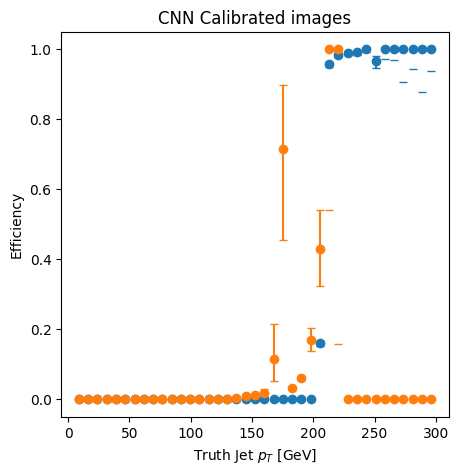

In [25]:
from utils.image import plot_turn_on

fig, ax = plt.subplots(figsize=(5, 5))

matched_reco, matched_truth = truth_match(calib_jets, truth_jets, max_dR=0.4)
matched_truth = sort_and_pad(matched_truth, 10)

plot_turn_on(
    truth_jets[...,0].rho,
    matched_truth[...,0].rho>thresholds['ptj1'],
    weights = None,
    bins    = np.linspace(5, 300, 40),
    ax      = ax, 
    label   = 'CNN Calibrated images',
)

plot_turn_on(
    truth_jets[...,3].rho,
    matched_truth[...,3].rho>thresholds['ptj4'],
    weights = None,
    bins    = np.linspace(5, 300, 40),
    ax      = ax,
    label   = 'CNN Calibrated images',
)